In [ ]:
import os
os.chdir(r'Path')
import torch
import torch.autograd as autograd
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import time
import scipy.io
import math
import scipy
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
import matplotlib.pyplot as plt
import operator
from functools import reduce
from functools import partial
from timeit import default_timer
from torch.autograd import Variable
import os
import csv
from torch.autograd.functional import jacobian

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

dim = 2

path = 'Package_Square.mat'

def derivee(y,x):
  return autograd.grad(y,x,torch.ones_like(y),retain_graph=True,create_graph=True)[0]

def som(s):
  return torch.sum(s,dim=-1,keepdim=True)


cuda


In [ ]:
class Offline:
    def __init__(self, path):
        Data = scipy.io.loadmat(path)
        # Euclidean Coordinates
        coor = torch.tensor(Data['nodes'], dtype = torch.float32).to(device)
        self.X = coor[:,0:1].to(device)
        self.Y = coor[:,1:2].to(device)
        # LBO Eigenfunctions and their Derivatives
        self.Phi = torch.tensor(Data['phi'], dtype = torch.float32).to(device)
        self.dPhi_dx = torch.tensor(Data['dphi_dx'], dtype = torch.float32).to(device)
        self.dPhi_dy = torch.tensor(Data['dphi_dy'], dtype = torch.float32).to(device)
        self.d2Phi_dx2 = torch.tensor(Data['d2phi_dx2'], dtype = torch.float32).to(device)
        self.d2Phi_dy2 = torch.tensor(Data['d2phi_dy2'], dtype = torch.float32).to(device)
        # Label of Nodes
        bc1_nodes = torch.tensor(Data['bc1_nodes'].astype(np.float32), dtype = torch.float32).to(device).squeeze()
        bc2_nodes = torch.tensor(Data['bc2_nodes'].astype(np.float32), dtype = torch.float32).to(device).squeeze()
        interior_nodes = torch.tensor(Data['interior_nodes'].astype(np.float32), dtype = torch.float32).to(device).squeeze()
        # Collocations of Boundary condition loss
        self.L_dbc = bc1_nodes - 1.0
        self.L_nbc = bc2_nodes - 1.0
        # Collocations of Boundary condition loss
        self.L_pde = interior_nodes - 1.0

    def forward(self, labels, n, **kwargs):
        attribute_map = {'x': ('X', True),'y': ('Y', True),
                  'phi': ('Phi', False),'dphi_dx': ('dPhi_dx', False),'dphi_dy': ('dPhi_dy', False),
                  'd2phi_dx2': ('d2Phi_dx2', False),'d2phi_dy2': ('d2Phi_dy2', False)}
        output = []
        for key, (attr, default) in attribute_map.items():
            if kwargs.get(key, default):
                output.append(getattr(self, attr)[labels.int(), :n])
        return tuple(output)


In [ ]:
class Online:
    def __init__(self, path, off, model):
        # Database from Offline Stage
        self.off = off
        # Model of Solution
        self.model = model
        # Physics Parameters
        E, mu = 1.0, 0.3
        # Constitutives
        Cons = E/(1-mu**2)*torch.tensor([[1,mu,0],[mu,1,0],[0,0,0.5*(1-mu)]]).to(device)
        self.c1,self.c2,self.c3 = Cons[0,0],Cons[0,1],Cons[2,2]

    def label_pde(self):
        L_pde = self.off.L_pde
        return L_pde

    def Nbc_loss(self):
        x, y, dphi_dx, dphi_dy = self.off.forward(self.off.L_nbc, n_sigma, dphi_dx=True, dphi_dy=True)
        sigma_xx, sigma_xy, sigma_yx, sigma_yy, px, py = self.model.Fsigma(x,y,dphi_dx,dphi_dy)
        nbc_loss = F.mse_loss(sigma_xy, torch.zeros_like(sigma_xy)) + F.mse_loss(sigma_yy, x)
        # nbc_loss = F.mse_loss(sigma_xy, torch.zeros_like(sigma_xy)) + F.mse_loss(sigma_yy, torch.sin(x))
        return nbc_loss

    def Dbc_loss(self):
        x, y, phi = self.off.forward(self.off.L_dbc, n_u, phi=True)
        ux, uy = self.model(x, y, phi)
        dbc_loss = F.mse_loss(ux, torch.zeros_like(ux)) + F.mse_loss(uy, torch.zeros_like(uy))
        return dbc_loss

    def PDE_loss(self,label):

        x, y, dphi_dx, dphi_dy, d2phi_dx2, d2phi_dy2 = self.off.forward(label, n_sigma, dphi_dx=True, dphi_dy=True, d2phi_dx2=True, d2phi_dy2=True)
        x.requires_grad = True
        y.requires_grad = True
        sigma_xx, sigma_xy, sigma_yx, sigma_yy, px, py = self.model.Fsigma(x,y,dphi_dx,dphi_dy)

        dsigmaxx_dx = derivee(sigma_xx,x) + som(px * d2phi_dx2)
        dsigmaxy_dy = derivee(sigma_xy,y) + som(px * d2phi_dy2)
        dsigmayx_dx = derivee(sigma_yx,x) + som(py * d2phi_dx2)
        dsigmayy_dy = derivee(sigma_yy,y) + som(py * d2phi_dy2)

        pde_x = dsigmaxx_dx + dsigmaxy_dy
        pde_y = dsigmayx_dx + dsigmayy_dy

        pde_loss_x = F.mse_loss(pde_x, torch.zeros_like(pde_x))
        pde_loss_y = F.mse_loss(pde_y, torch.zeros_like(pde_y))

        return pde_loss_x + pde_loss_y

    def C_loss(self,label):

        x, y, phi, dphi_dx, dphi_dy = self.off.forward(label, n_u, phi=True, dphi_dx=True, dphi_dy=True)
        x.requires_grad = True
        y.requires_grad = True
        phi.requires_grad = True

        ux, uy = self.model(x,y,phi)

        epsilon_xx = derivee(ux,x) + som(derivee(ux,phi) * dphi_dx)
        epsilon_xy = derivee(ux,y) + som(derivee(ux,phi) * dphi_dy)
        epsilon_yx = derivee(uy,x) + som(derivee(uy,phi) * dphi_dx)
        epsilon_yy = derivee(uy,y) + som(derivee(uy,phi) * dphi_dy)

        sigma_xx0 = self.c1*epsilon_xx + self.c2*epsilon_yy
        sigma_xy0 = self.c3*epsilon_xy + self.c3*epsilon_yx
        sigma_yx0 = self.c3*epsilon_xy + self.c3*epsilon_yx
        sigma_yy0 = self.c2*epsilon_xx + self.c1*epsilon_yy

        x, y, phi, dphi_dx, dphi_dy = self.off.forward(label, n_sigma, phi=True, dphi_dx=True, dphi_dy=True)
        sigma_xx, sigma_xy, sigma_yx, sigma_yy, H1, H2 = self.model.Fsigma(x,y,dphi_dx,dphi_dy)

        loss_C = F.mse_loss(torch.cat((sigma_xx0,sigma_xy0,sigma_yx0,sigma_yy0),dim=-1), \
                    torch.cat((sigma_xx,sigma_xy,sigma_yx,sigma_yy),dim=-1))

        return loss_C

In [ ]:
class MLP_gelu(nn.Module):
    def __init__(self,insize,outsize,width,layers):
        super().__init__()
        self.input_layer = nn.Linear(insize,width)
        self.hidden_layers = nn.ModuleList([])
        self.output_layer = nn.Linear(width,outsize)
        for i in range(layers):
          self.linear_layer = nn.Linear(width,width)
          self.hidden_layers.append(self.linear_layer)
        self.layers = layers

    def forward(self, x): # F.gelu
        layer_out = F.gelu(self.input_layer(x))
        for i in range(self.layers):
            layer_out = F.gelu(self.hidden_layers[i](layer_out))
        layer_out = self.output_layer(layer_out)
        return layer_out

class Finite_PINN(nn.Module):
    def __init__(self, n_sigma, n_u):
        super(Finite_PINN, self).__init__()

        width = 128
        self.NN_H1 = MLP_gelu(2,n_sigma,width,4)
        self.NN_H2 = MLP_gelu(2,n_sigma,width,4)
        self.NN_eu1 = MLP_gelu(2+n_u,1,width,4)
        self.NN_eu2 = MLP_gelu(2+n_u,1,width,4)

    def forward(self, x, y, u):

        v1 = self.NN_eu1(torch.cat((x,y,u),dim=-1))
        v2 = self.NN_eu2(torch.cat((x,y,u),dim=-1))

        return v1,v2

    def Fsigma(self, x, y, du_dx, du_dy):

        px = self.NN_H1(torch.cat((x,y),dim=-1))
        py = self.NN_H2(torch.cat((x,y),dim=-1))

        sig_xx, sig_xy = som(px * du_dx), som(px * du_dy)
        sig_yx, sig_yy = som(py * du_dx), som(py * du_dy)

        return sig_xx,sig_xy,sig_yx,sig_yy,px,py


In [ ]:
n_sigma = 4
n_u = 4

OFF = Offline(path)
model = Finite_PINN(n_sigma = n_sigma, n_u = n_u).to(device, dtype = torch.float32)
ON = Online(path,OFF,model)

L_pde = ON.label_pde()
dataset = torch.utils.data.TensorDataset(L_pde,torch.zeros_like(L_pde))
trainset = torch.utils.data.DataLoader(dataset, batch_size=200, shuffle=True, drop_last=True)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
num_epochs = 1000
csize = 4

for ep in range(num_epochs):
    model.train()
    t1 = default_timer()
    bc_mse,pde_mse,c_mse = 0,0,0
    ne = 0

    for l_pde, r_pde in trainset:

        ne += 1
        optimizer.zero_grad()

        # Boundary Condition Loss
        dbc_loss = ON.Dbc_loss()
        nbc_loss = ON.Nbc_loss()
        # PDE Loss
        pde_loss = ON.PDE_loss(l_pde)
        # Constitutive loss
        C_loss = ON.C_loss(l_pde)

        Loss = dbc_loss + nbc_loss + pde_loss + C_loss

        Loss.backward()
        optimizer.step()

        bc_mse += dbc_loss.item() + nbc_loss.item()
        pde_mse += pde_loss.item()
        c_mse += C_loss.item()

    bc_mse /= ne
    pde_mse /= ne
    c_mse /= ne

    t2 = default_timer()

    print(f'Epoch:{ep+1}, Time:{t2-t1:.3g}s, BC Loss:{bc_mse:.3e}, PDE Loss:{pde_mse:.3e}, C Loss:{c_mse:.3e}')


Epoch:1, Time:1.54s, BC Loss:4.723e-04, PDE Loss:5.341e-03, C Loss:1.282e-03
Epoch:2, Time:1.54s, BC Loss:3.607e-04, PDE Loss:4.285e-03, C Loss:1.204e-03
Epoch:3, Time:1.42s, BC Loss:3.543e-04, PDE Loss:3.870e-03, C Loss:1.138e-03
Epoch:4, Time:1.45s, BC Loss:3.539e-04, PDE Loss:3.570e-03, C Loss:1.068e-03
Epoch:5, Time:1.4s, BC Loss:3.538e-04, PDE Loss:3.257e-03, C Loss:1.013e-03
Epoch:6, Time:1.52s, BC Loss:3.471e-04, PDE Loss:2.962e-03, C Loss:9.589e-04
Epoch:7, Time:1.46s, BC Loss:3.359e-04, PDE Loss:2.741e-03, C Loss:9.206e-04
Epoch:8, Time:1.41s, BC Loss:3.359e-04, PDE Loss:2.605e-03, C Loss:8.819e-04
Epoch:9, Time:1.4s, BC Loss:3.585e-04, PDE Loss:2.688e-03, C Loss:8.538e-04
Epoch:10, Time:1.51s, BC Loss:3.227e-04, PDE Loss:2.425e-03, C Loss:8.262e-04
Epoch:11, Time:1.41s, BC Loss:3.133e-04, PDE Loss:2.351e-03, C Loss:8.070e-04
Epoch:12, Time:1.29s, BC Loss:3.087e-04, PDE Loss:2.188e-03, C Loss:7.848e-04
Epoch:13, Time:1.38s, BC Loss:3.103e-04, PDE Loss:2.205e-03, C Loss:7.699e-

KeyboardInterrupt: 

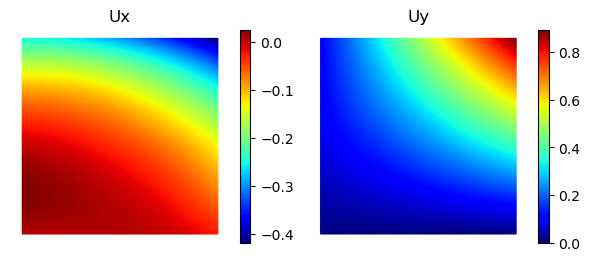

In [ ]:
model.eval()
X_plot, Y_plot, Phi_plot = OFF.X, OFF.Y, OFF.Phi[:,:n_u]
vx_plot, vy_plot = model(OFF.X, OFF.Y, OFF.Phi[:,:n_u])
vx_plot = vx_plot.squeeze().squeeze().detach().cpu()
vy_plot = vy_plot.squeeze().squeeze().detach().cpu()
plt.figure(figsize=(6, 5))
plt.subplot(2, 2, 1)
plt.scatter(X_plot.squeeze().detach().cpu(), Y_plot.squeeze().detach().cpu(), c=vx_plot, s = 1.5, cmap='jet')
plt.title('Ux')
plt.axis('equal')
plt.axis('off')
plt.colorbar(fraction=0.046, pad=0.04)
plt.subplot(2, 2, 2)
plt.scatter(X_plot.squeeze().detach().cpu(), Y_plot.squeeze().detach().cpu(), c=vy_plot, s = 1.5, cmap='jet')
plt.title('Uy')
plt.axis('equal')
plt.axis('off')
plt.colorbar(fraction=0.046, pad=0.04)
plt.savefig('square.png')
plt.tight_layout()
plt.show()